In [1]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy import stats
from astropy.io import fits

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math


In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [3]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [4]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')

am.xants = []


In [5]:

v = deepcopy(uv)


In [6]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))


In [7]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)


In [8]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 2.*np.pi / B
    
    tau = dist / c
    
    temp = np.zeros((60,1024,4))
    
    T = uv.Ntimes*10
    
    del_nu = 2.*np.pi / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(int(math.ceil(float(tau/del_tau)))):
            
            temp[i][j][0]= np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
            if (i != 0):
            
                temp[-i][j][0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
    result = np.fft.fftn(temp)
    
    return result


In [9]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
  

In [10]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [11]:

def noise(amp,width):
    
    result = np.random.normal(amp,width,(60,1024,4))
    
    return result


In [12]:

def generate_random_data(i_width,n_width):
    
    
    new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)
    
    s_amp = 0
    
    s_width = 1
    
    i_amp = 0
    
    n_amp = 0
    
    for i in reds:
        
        sig = signal(s_amp,s_width,i[0])
        
        for j in i:
            
            indices = v.antpair2ind(j[0],j[1])
            
            noi = noise(n_amp,n_width)
        
            i_sig = signal(i_amp,i_width,j)
            
            norm_power = float(s_width**2)
            
            new_power = float(norm_power + i_width**2)
            
            ratio = np.sqrt(norm_power/new_power)
            
            sigs = (sig + i_sig) * ratio
            
            visibility = sigs + noi
            
            new_data_array[indices,0,:,:] = visibility
            
            
    for k in nonreds:
        
        sig = signal(s_amp,s_width,k)
        
        i_sig = signal(i_amp,i_width,j)
        
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2)
            
        ratio = np.sqrt(norm_power/new_power)
            
        sigs = (sig + i_sig) * ratio
            
        indices = v.antpair2ind(k[0],k[1])
            
        noi = noise(n_amp,n_width)
            
        visibility = sig + noi
            
        new_data_array[indices,0,:,:] = visibility
        
        return new_data_array


In [13]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,4)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            values = []
            
            values_raw = []

            for key in z_scores.keys():
                
                values.append(z_scores[key])
                
                values_raw.append(rawRed[key])
                
            a = np.array(values).mean()
            
            b = np.array(values).std()
            
            c = np.array(values_raw).mean()
            
            d = np.array(values_raw).std()
                
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b

            new_array[i][j][2] = c
            
            new_array[i][j][3] = d

            
    return new_array
            
            
    


In [14]:

input_array = []

for i in range(10):
    
    input_array.append([])
    
    for j in range(10):
        
        input_array[i].append([])


In [15]:

i_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]

npar = 5.89945508026

n_vals = [0,npar/4.,npar/2.,3*npar/4.,npar,5*npar/4.,3*npar/2.,2*npar,3*npar,4*npar]


In [16]:

for i in range(10):
    
    for j in range(10):
        
        input_array[i][j] = (i_vals[i],n_vals[j])


In [17]:
print input_array

[[(0, 0), (0, 1.474863770065), (0, 2.94972754013), (0, 4.424591310195), (0, 5.89945508026), (0, 7.374318850325), (0, 8.84918262039), (0, 11.79891016052), (0, 17.69836524078), (0, 23.59782032104)], [(0.25, 0), (0.25, 1.474863770065), (0.25, 2.94972754013), (0.25, 4.424591310195), (0.25, 5.89945508026), (0.25, 7.374318850325), (0.25, 8.84918262039), (0.25, 11.79891016052), (0.25, 17.69836524078), (0.25, 23.59782032104)], [(0.5, 0), (0.5, 1.474863770065), (0.5, 2.94972754013), (0.5, 4.424591310195), (0.5, 5.89945508026), (0.5, 7.374318850325), (0.5, 8.84918262039), (0.5, 11.79891016052), (0.5, 17.69836524078), (0.5, 23.59782032104)], [(0.75, 0), (0.75, 1.474863770065), (0.75, 2.94972754013), (0.75, 4.424591310195), (0.75, 5.89945508026), (0.75, 7.374318850325), (0.75, 8.84918262039), (0.75, 11.79891016052), (0.75, 17.69836524078), (0.75, 23.59782032104)], [(1.0, 0), (1.0, 1.474863770065), (1.0, 2.94972754013), (1.0, 4.424591310195), (1.0, 5.89945508026), (1.0, 7.374318850325), (1.0, 8.849

In [18]:

#holder_array_mkIII = generate_random_array(input_array)

#np.savez('holder_array_mkIII.npz',holder_array_mkIII)


In [19]:

data = np.load('holder_array_mkIII.npz')

holder_array = data['arr_0']

#holder_array = holder_array_mkIII


In [20]:
print holder_array

[[[             nan              nan   1.00000000e+00   0.00000000e+00]
  [  2.04427591e-01   9.18802275e-01   9.33640592e-01   6.92540392e-03]
  [ -2.72255231e-04   8.43566647e-01   7.71250255e-01   2.04542234e-02]
  [  1.45558501e-02   9.15985584e-01   6.35559508e-01   2.09354108e-02]
  [  4.88985449e-02   9.03752410e-01   4.87351620e-01   2.65626371e-02]
  [  1.21863135e-01   9.06968078e-01   4.07179875e-01   2.15946207e-02]
  [  4.37890079e-02   9.24862370e-01   3.38873207e-01   1.93687444e-02]
  [  2.30437000e-01   9.73380299e-01   2.29418545e-01   1.49475269e-02]
  [  5.75582151e-02   8.79500518e-01   1.46928545e-01   7.51448400e-03]
  [  1.61497962e-01   9.92614255e-01   1.17041538e-01   4.20944141e-03]]

 [[ -8.36048611e-02   9.75130182e-01   9.74104785e-01   2.17027082e-03]
  [  7.49136137e-02   9.31007312e-01   9.05616764e-01   6.59558520e-03]
  [  2.18040936e-02   8.31869392e-01   7.60127549e-01   1.69766495e-02]
  [  5.05196583e-02   9.21442600e-01   6.05314709e-01   2.3691

In [21]:
print holder_array[0][0][1] 

nan


In [22]:
holder_array[0][0][0] = 0.
holder_array[0][0][1] = 0


print holder_array

[[[  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00]
  [  2.04427591e-01   9.18802275e-01   9.33640592e-01   6.92540392e-03]
  [ -2.72255231e-04   8.43566647e-01   7.71250255e-01   2.04542234e-02]
  [  1.45558501e-02   9.15985584e-01   6.35559508e-01   2.09354108e-02]
  [  4.88985449e-02   9.03752410e-01   4.87351620e-01   2.65626371e-02]
  [  1.21863135e-01   9.06968078e-01   4.07179875e-01   2.15946207e-02]
  [  4.37890079e-02   9.24862370e-01   3.38873207e-01   1.93687444e-02]
  [  2.30437000e-01   9.73380299e-01   2.29418545e-01   1.49475269e-02]
  [  5.75582151e-02   8.79500518e-01   1.46928545e-01   7.51448400e-03]
  [  1.61497962e-01   9.92614255e-01   1.17041538e-01   4.20944141e-03]]

 [[ -8.36048611e-02   9.75130182e-01   9.74104785e-01   2.17027082e-03]
  [  7.49136137e-02   9.31007312e-01   9.05616764e-01   6.59558520e-03]
  [  2.18040936e-02   8.31869392e-01   7.60127549e-01   1.69766495e-02]
  [  5.05196583e-02   9.21442600e-01   6.05314709e-01   2.3691

In [23]:
array_1 = []

for i in range(10):
    
    array_1.append([])
    
    for j in range(10):
        
        array_1[i].append(holder_array[i][j][0])
        
print array_1

[[0.0, 0.20442759083366033, -0.00027225523114278861, 0.014555850106102627, 0.048898544919380088, 0.12186313538014235, 0.043789007947750314, 0.23043700000302453, 0.057558215128495106, 0.16149796226940577], [-0.08360486110591113, 0.0749136136645253, 0.021804093584520998, 0.050519658343564616, 0.1134695622120169, 0.15177483259053282, 0.27082477882336392, 0.074081876899596222, 0.10659290591310445, 0.1752645446045879], [-0.12213398838739618, 0.16114465616663962, 0.21014653371310399, 0.15846112813071231, 0.066792194685434389, 0.082652527833077374, 0.19389421823914679, 0.16914890730657078, 0.20693326638377529, 0.15926849525082612], [-0.040225195849319231, 0.18122561965511838, 0.013637633277700699, 0.00072084940275720061, 0.14268623211612608, 0.11038138097972679, 0.10154835054866077, 0.10960569935224307, 0.092785002118144375, 0.12019904546494457], [-0.057016514971040898, 0.10090518941324753, 0.094255317692769749, 0.17526058496045863, 0.11701913771869964, 0.16410676707334207, 0.1683771546522119

In [24]:
array_2 = []

for i in range(10):
    
    array_2.append([])
    
    for j in range(10):
        
        array_2[i].append(holder_array[i][j][1])
        
print array_2

[[0.0, 0.91880227497083078, 0.84356664673188375, 0.91598558372312966, 0.9037524101740364, 0.90696807804443513, 0.92486236983255488, 0.97338029853062513, 0.87950051758429859, 0.99261425518441515], [0.9751301815547998, 0.93100731181630791, 0.83186939244244396, 0.92144260008328049, 0.93722743121763075, 0.85245956606753115, 0.95432906804262574, 0.88696624958043024, 0.92245934026169862, 1.0015748059615066], [1.020892310380437, 1.1650752704016496, 1.0231349855422978, 0.98003727190505108, 0.92663841793016155, 1.0081092408242824, 0.93530930310908178, 1.02186265375713, 0.9534891682287906, 0.9378170626154686], [0.94460127430913277, 1.0079285017416189, 0.95478107604129192, 0.82733646300861419, 0.9799813565503922, 0.99443656517638312, 0.91815419571657919, 0.87664437218380975, 0.95280448206308688, 1.0236421416189674], [1.021419421277775, 0.89868363265686346, 1.0187196670597742, 1.0131112511168059, 0.94327964565846867, 0.95119109214358144, 0.97834400392642329, 1.0189374360857888, 0.9761009560992735,

In [25]:
array_3 = []

for i in range(10):
    
    array_3.append([])
    
    for j in range(10):
        
        array_3[i].append(holder_array[i][j][2])
        
print array_3

[[1.0, 0.9336405921795875, 0.77125025545646786, 0.63555950812332562, 0.48735162030226148, 0.40717987476782397, 0.33887320658047121, 0.22941854465621114, 0.14692854517761106, 0.11704153791469082], [0.97410478458016869, 0.90561676441110583, 0.76012754866374377, 0.60531470948203436, 0.49013656067645822, 0.41866183241813693, 0.31938832562626279, 0.23003588935313629, 0.14560446842687896, 0.11810884840635162], [0.92412175967860966, 0.87020612865564739, 0.7397896533142122, 0.58319277282961635, 0.46001461108500091, 0.37917857048854386, 0.30956017991053525, 0.21891859781548642, 0.14633834671945983, 0.11559911930707191], [0.90215087428283158, 0.84380269744716607, 0.70577268276498972, 0.56606214718473935, 0.44871519955580358, 0.37452961120221206, 0.3043139264895518, 0.21569456651680405, 0.14394694929592355, 0.11709342012379526], [0.90249608419476601, 0.8425284406523984, 0.70947679621099091, 0.57025086424182714, 0.45190320466482931, 0.36342175235072161, 0.29619123215732701, 0.21865373233286467, 0.

In [26]:
array_4 = []

for i in range(10):
    
    array_4.append([])
    
    for j in range(10):
        
        array_4[i].append(holder_array[i][j][3])
        
print array_4

[[0.0, 0.0069254039151587432, 0.020454223372903854, 0.020935410786366529, 0.026562637148925188, 0.02159462072094686, 0.019368744355959949, 0.014947526876979093, 0.0075144839953960206, 0.0042094414091021441], [0.0021702708224196347, 0.0065955851956760111, 0.016976649458262848, 0.023691560785814546, 0.022935479959089906, 0.017513392814561012, 0.019733535009577637, 0.013256700143394789, 0.0071702313375867893, 0.0038395372113982458], [0.0037268494151986263, 0.0047869508093713511, 0.014320358449243563, 0.019467059919127717, 0.022306213926831527, 0.019394776940804409, 0.018272897731489896, 0.013630221806506615, 0.0069645240773018712, 0.0039542351963657409], [0.0040284814464548865, 0.0066744323154115841, 0.017182962525575319, 0.019211463881071086, 0.021931422396386794, 0.018647134545900293, 0.017927283600047673, 0.012689140413515418, 0.0068611195688284268, 0.0040865246002692321], [0.0039353634214218027, 0.0060546353990131932, 0.014985491091786067, 0.01956263222521273, 0.020750746256713123, 0.

<IPython.core.display.Javascript object>


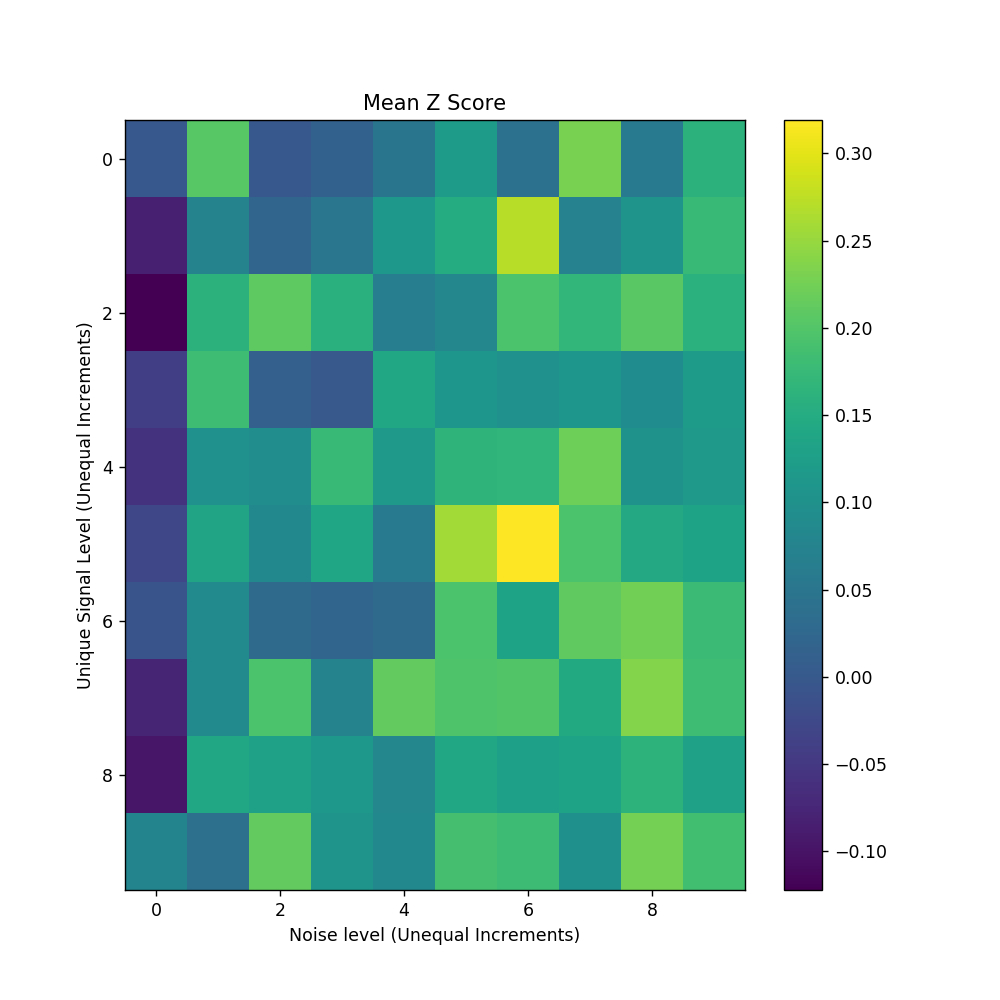

In [27]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto')
plt.title('Mean Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


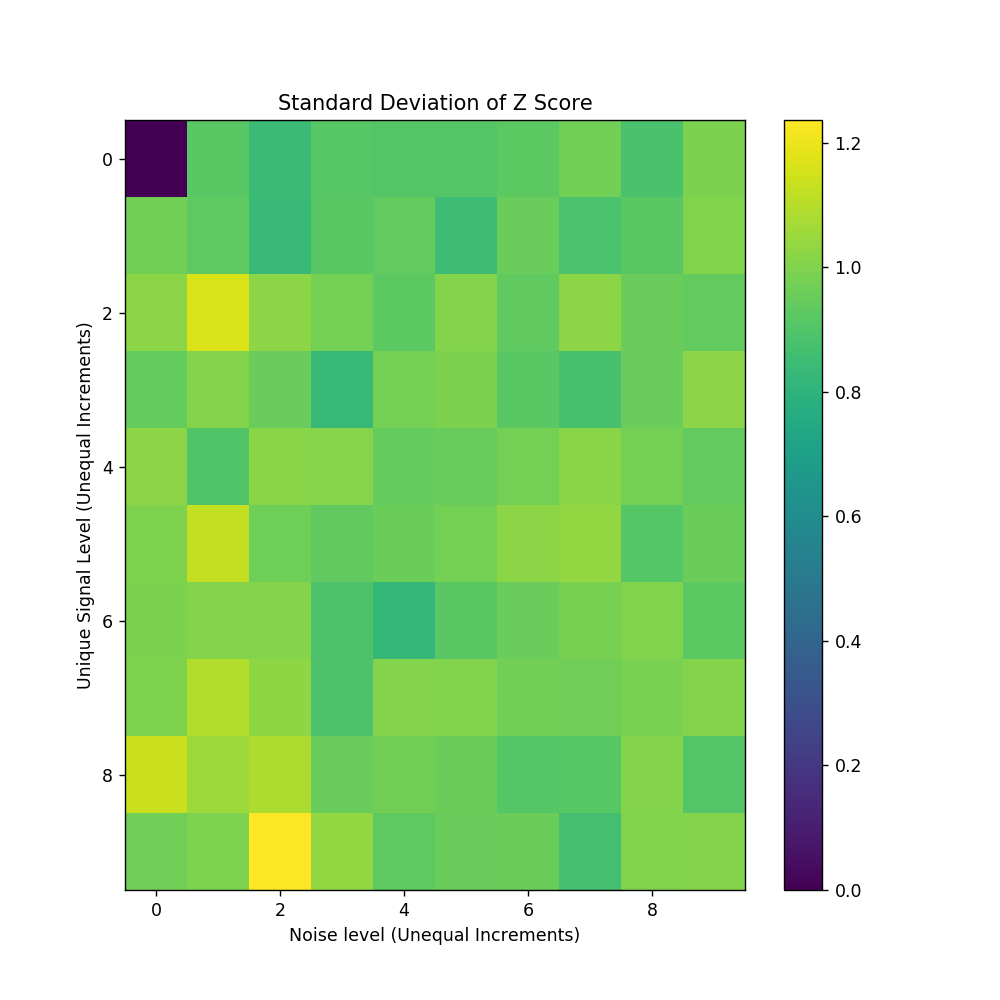

In [28]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto')
plt.title('Standard Deviation of Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


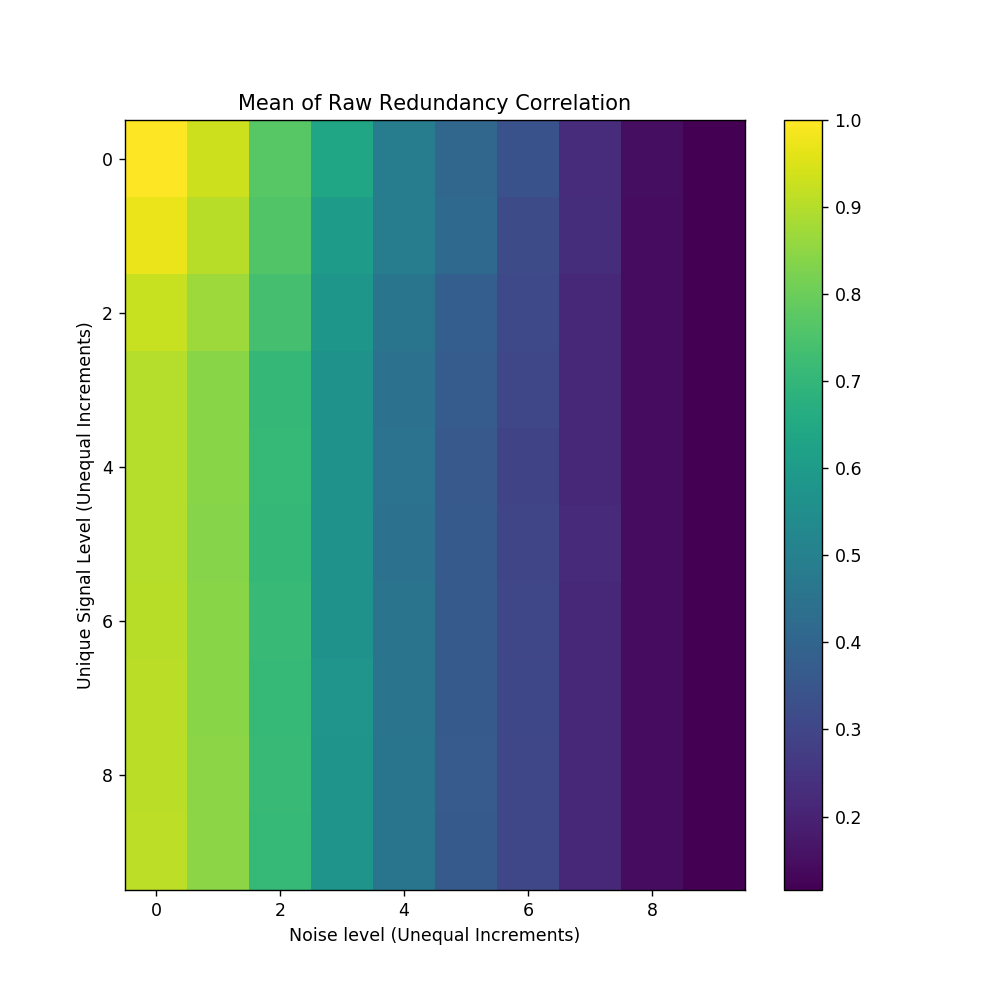

In [29]:

plt.figure(figsize=(8,8))
plt.imshow(array_3,aspect='auto')
plt.title('Mean of Raw Redundancy Correlation')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


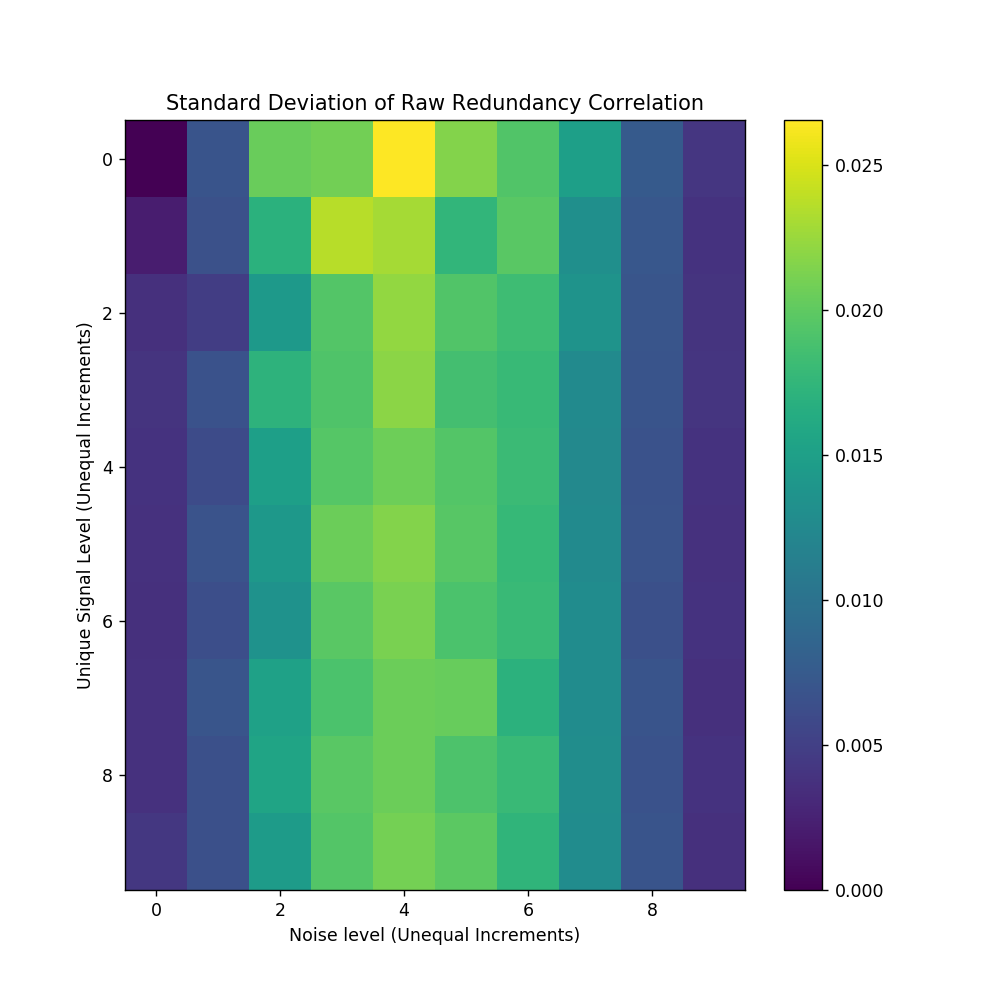

In [30]:

plt.figure(figsize=(8,8))
plt.imshow(array_4,aspect='auto')
plt.title('Standard Deviation of Raw Redundancy Correlation')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [31]:

slice_1 = []
slice_2 = []
slice_3 = []


for i in holder_array:
    
    slice_1.append(i[0][2])
    
    slice_2.append(i[4][2])
    
    slice_3.append(i[9][2])
    

In [32]:

err_1 = []
err_2 = []
err_3 = []

for i in holder_array:
    
    err_1.append(i[0][3])
    
    err_2.append(i[4][3])
    
    err_3.append(i[9][3])


<IPython.core.display.Javascript object>


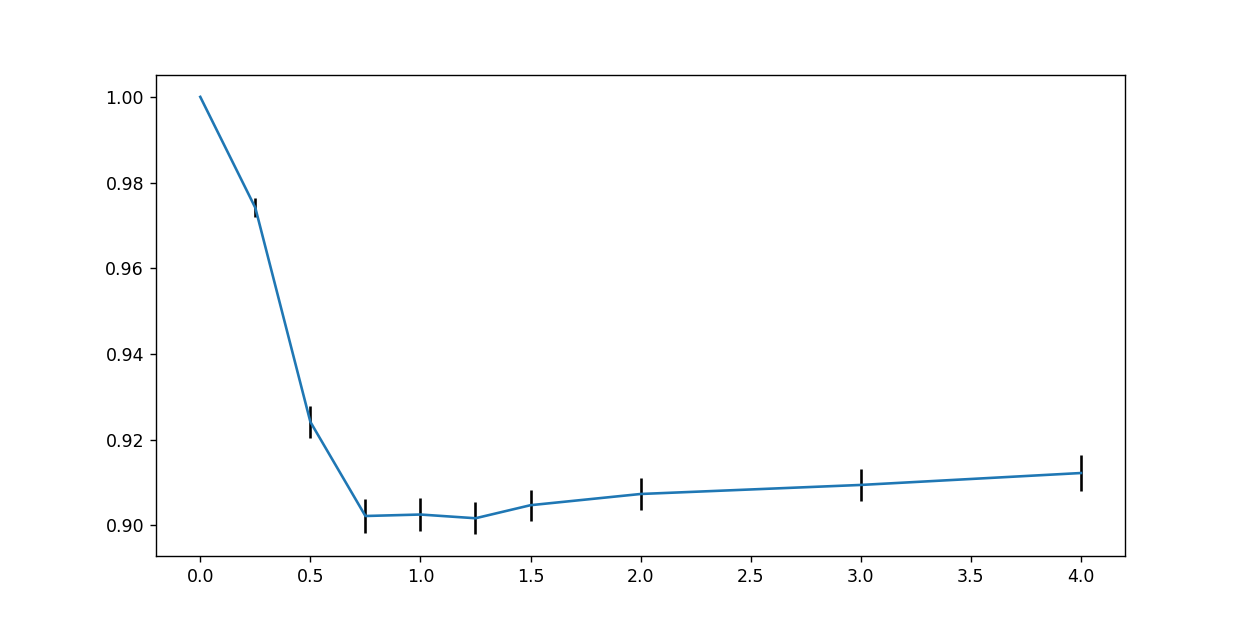

In [33]:

plt.figure(figsize = (10,5))
plt.errorbar(i_vals,slice_1,yerr=err_1,ecolor = 'k')

plt.show()


<IPython.core.display.Javascript object>


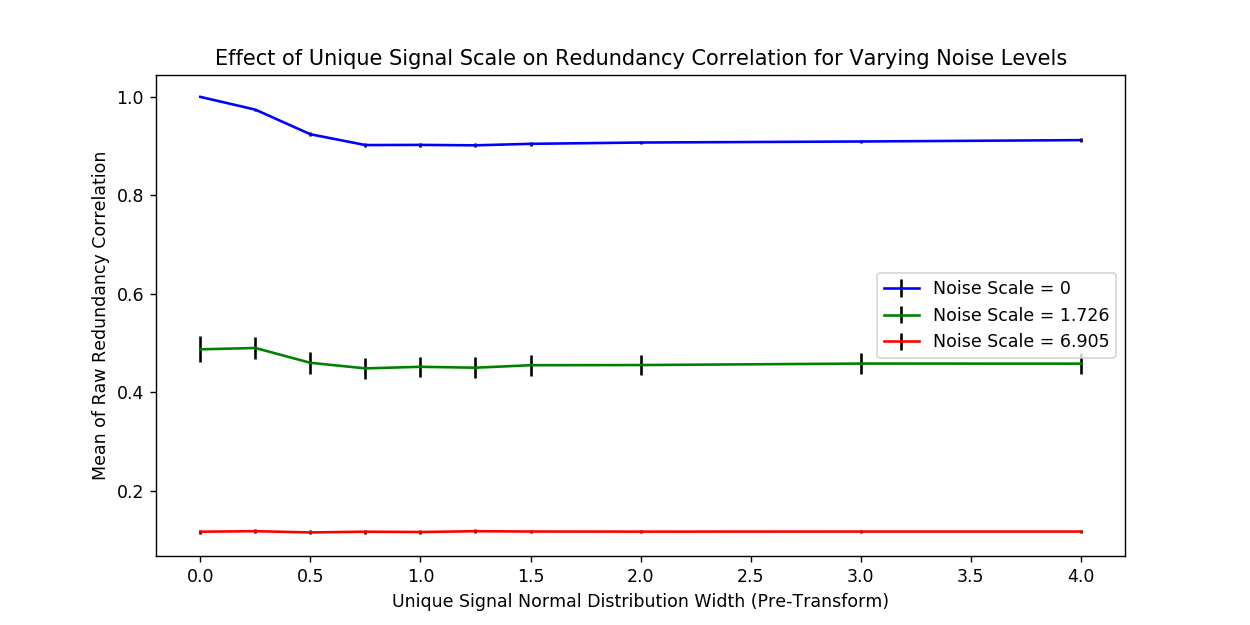

In [34]:

plt.figure(figsize = (10,5))
plt.errorbar(i_vals,slice_1,yerr=err_1,ecolor = 'k',c = 'b',label = 'Noise Scale = 0')
plt.errorbar(i_vals,slice_2,yerr=err_2,ecolor = 'k',c = 'g',label = 'Noise Scale = 1.726')
plt.errorbar(i_vals,slice_3,yerr=err_3,ecolor = 'k',c = 'r',label = 'Noise Scale = 6.905')
plt.xlabel('Unique Signal Normal Distribution Width (Pre-Transform)')
plt.ylabel('Mean of Raw Redundancy Correlation')
plt.legend()
plt.title('Effect of Unique Signal Scale on Redundancy Correlation for Varying Noise Levels')
plt.show()
